In [25]:
import pandas as pd
import numpy as np

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [27]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

In [28]:
file_path = "../data/online_retail_II.xlsx"
df = pd.read_excel(file_path, sheet_name='Year 2010-2011')

In [29]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [30]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

In [31]:
df = df.dropna(subset=['Customer ID'])

In [32]:
# removing cancelled orders
df = df[~df["Invoice"].astype(str).str.startswith('C')]

In [33]:
df = df[(df['Quantity'] > 0) & (df['Price'] > 0 )]

In [34]:
df['Revenue'] = df['Quantity'] * df['Price']

In [36]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [48]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID,Revenue,Year,Month
count,397885.000000,397885,397885.000000,397885.000000,397885.000000,397885.000000,397885.000000
mean,12.988208,2011-07-10 23:41:56.419316992,3.116525,15294.416882,22.396989,2010.934260,7.612486
min,1.000000,2010-12-01 08:26:00,0.001000,12346.000000,0.001000,2010.000000,1.000000
25%,2.000000,2011-04-07 11:12:00,1.250000,13969.000000,4.680000,2011.000000,5.000000
50%,6.000000,2011-07-31 14:39:00,1.950000,15159.000000,11.800000,2011.000000,8.000000
75%,12.000000,2011-10-20 14:33:00,3.750000,16795.000000,19.800000,2011.000000,11.000000
max,80995.000000,2011-12-09 12:50:00,8142.750000,18287.000000,168469.600000,2011.000000,12.000000
std,179.331551,NaN,22.097861,1713.144421,309.070653,0.247828,3.416522


In [38]:
df['Year'] = df['InvoiceDate'].dt.year

In [39]:
df['Month'] = df['InvoiceDate'].dt.month

In [40]:
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()

In [42]:
# Aggregate revenue by month
monthly_revenue = df.groupby(['Year','Month'])['Revenue'].sum().reset_index()

In [43]:
# Aggregate revenue by country
country_revenue = df.groupby('Country')['Revenue'].sum().sort_values(ascending=False).reset_index()

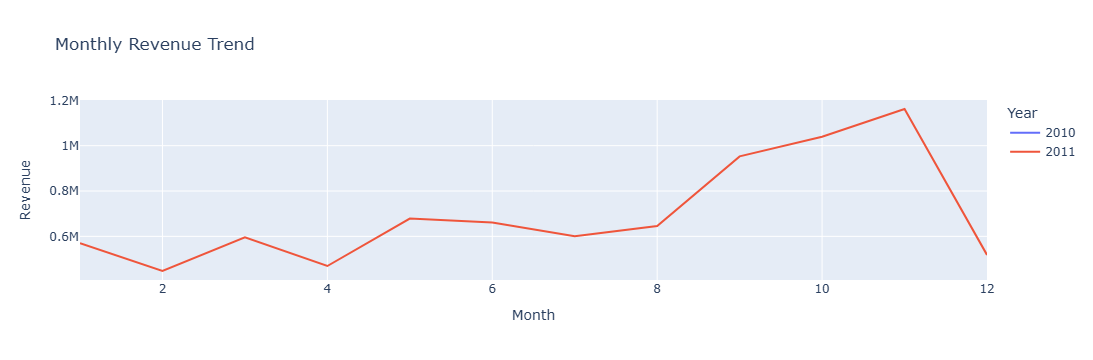

In [44]:
fig = px.line(monthly_revenue, 
              x='Month', 
              y='Revenue', 
              color='Year', 
              title='Monthly Revenue Trend')
fig.show()

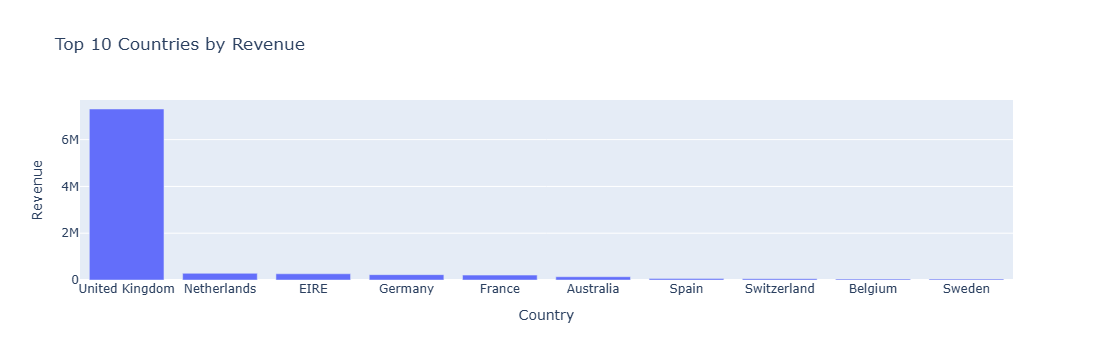

In [45]:
fig = px.bar(country_revenue.head(10), 
             x='Country', 
             y='Revenue', 
             title='Top 10 Countries by Revenue')
fig.show()

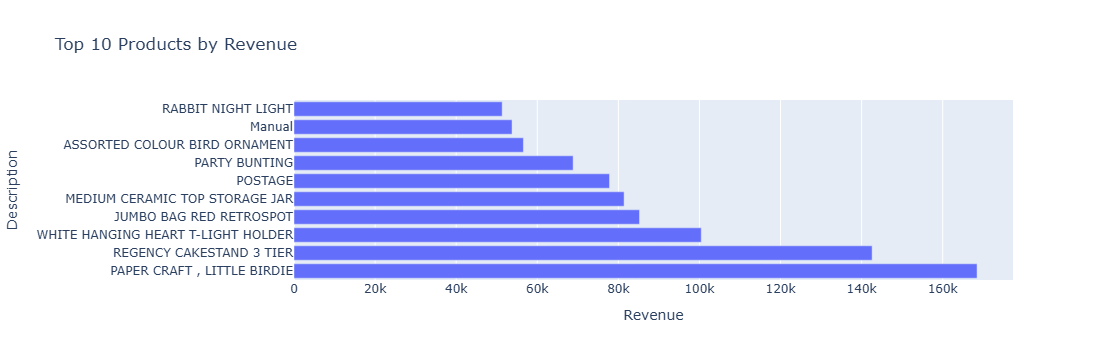

In [46]:
top_products = df.groupby('Description')['Revenue'].sum().sort_values(ascending=False).head(10).reset_index()

fig = px.bar(top_products, x='Revenue', y='Description', orientation='h', title='Top 10 Products by Revenue')
fig.show()

In [47]:
# Compute a reference date (the day after the latest transaction)
ref_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = (
    df.groupby('Customer ID')
      .agg({
          'InvoiceDate': lambda x: (ref_date - x.max()).days,  # Recency
          'Invoice': 'nunique',                                # Frequency
          'Revenue': 'sum'                                     # Monetary
      })
      .rename(columns={'InvoiceDate': 'Recency', 'Invoice': 'Frequency', 'Revenue': 'Monetary'})
      .reset_index()
)

rfm.head()

,Customer ID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [49]:
# Higher Frequency/Monetary → higher score; lower Recency → higher score
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)

rfm['RFM_Score'] = rfm['R_Score'] + rfm['F_Score'] + rfm['M_Score']
rfm.head()

,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,12346.0,326,1,77183.60,1,1,5,7
1,12347.0,2,7,4310.00,5,5,5,15
2,12348.0,75,4,1797.24,2,4,4,10
3,12349.0,19,1,1757.55,4,1,4,9
4,12350.0,310,1,334.40,1,1,2,4


In [51]:
def segment_customer(score):
    if score >= 13:
        return 'Champions'
    elif score >= 10:
        return 'Loyal Customers'
    elif score >= 7:
        return 'Potential Loyalist'
    elif score >= 5:
        return 'At Risk'
    else:
        return 'Lost'

rfm['Segment'] = rfm['RFM_Score'].apply(segment_customer)
rfm['Segment'].value_counts()


Segment
Potential Loyalist    1092
Loyal Customers       1008
Champions              934
At Risk                759
Lost                   545
Name: count, dtype: int64

C:\Users\nepal\AppData\Local\Temp\ipykernel_10872\917225872.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




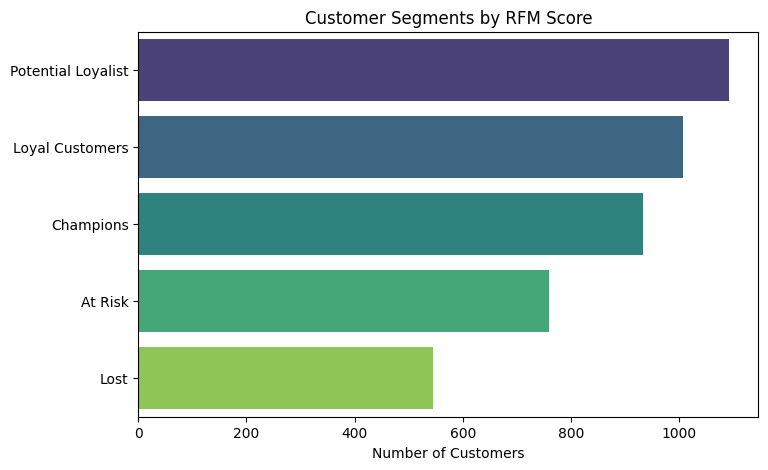

In [54]:
plt.figure(figsize=(8,5))
sns.countplot(y='Segment', data=rfm, order=rfm['Segment'].value_counts().index, palette='viridis', )
plt.title('Customer Segments by RFM Score')
plt.xlabel('Number of Customers')
plt.ylabel('')
plt.show()

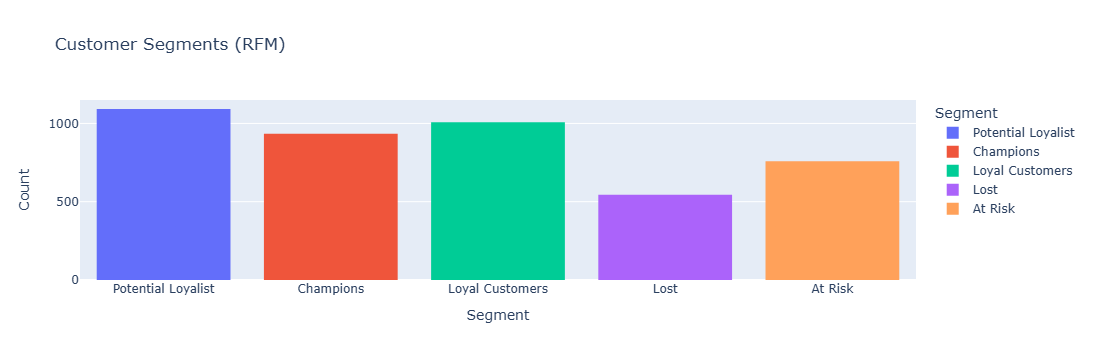

In [55]:
fig = px.histogram(rfm, x='Segment', color='Segment', title='Customer Segments (RFM)')
fig.update_layout(xaxis_title='Segment', yaxis_title='Count')
fig.show()

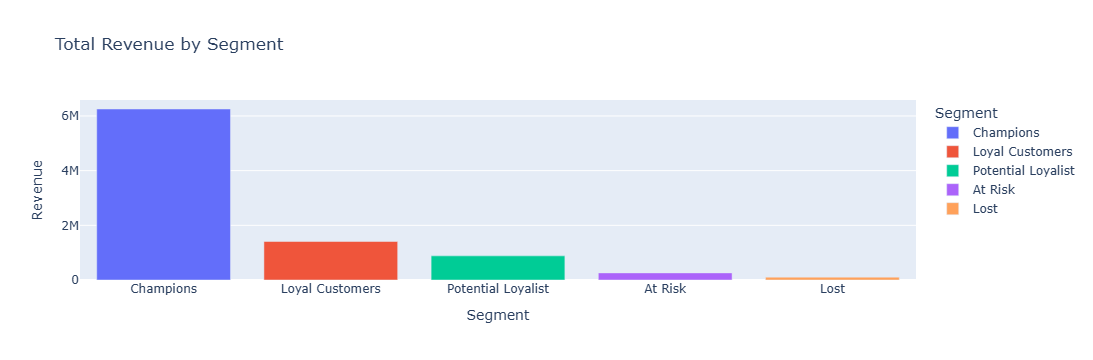

In [56]:
segment_summary = (
    df.merge(rfm[['Customer ID','Segment']], on='Customer ID')
      .groupby('Segment')['Revenue']
      .sum()
      .sort_values(ascending=False)
      .reset_index()
)

fig = px.bar(segment_summary, x='Segment', y='Revenue', color='Segment', title='Total Revenue by Segment')
fig.show()

In [57]:
rfm.to_csv('../outputs/customer_rfm_summary.csv', index=False)
segment_summary.to_csv('../outputs/segment_revenue.csv', index=False)